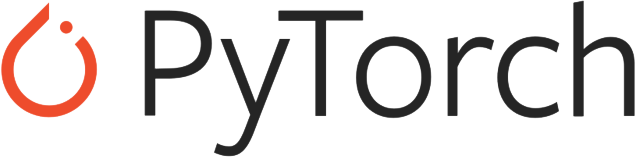
# Pytorch workshop parte II

Felipe Guzman

19-06-2023

En la primera etapa, explicamos qué es un tensor, cómo operar con él y sus principales utilidades, sentando los principios básicos de los gradientes, el grafo computacional y la retropropagación.

En esta parte, comenzaremos a abordar los problemas de optimización, el descenso de gradiente y el aprendizaje profundo.

## Optimización convexa

La optimización convexa es un campo de estudio en la optimización matemática que se enfoca en resolver problemas donde la función objetivo y las restricciones son funciones convexas. Se busca encontrar los valores de las variables que minimizan o maximizan la función objetivo, aprovechando las propiedades matemáticas de convexidad, como la convexidad del dominio y las curvas de nivel. La optimización convexa tiene aplicaciones en economía, estadística, aprendizaje automático y otras disciplinas, ofreciendo métodos eficientes y garantías teóricas de encontrar soluciones óptimas globales.

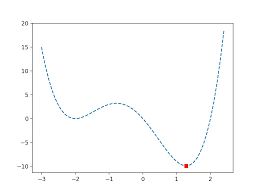

## Ejemplo de optimizacion básica

Vamos a suponer un simple escenario. Tenemos el siguiente modelo matemático:

$ y = f(x) = 3+2x+1x^3 $

como es común en los problemas de optimizacion supervisados, desconocemos $f(x)$ pero sabes que dado un valor de $x_1$ sabemos su valor de salida $y_1 = f(x_1)$. Con esto en mente vamos a crear datos de entrenamiento en base a entradas y salidas:

In [1]:
import torch
device = torch.device('cuda')

x_train = torch.tensor([0.,1.,2.,3.,4.,5.],device=device,requires_grad=True)
y_train = torch.tensor([3.,6.,11.,18.,27.,38.],device=device,requires_grad=True)

print(x_train)
print(y_train)

tensor([0., 1., 2., 3., 4., 5.], device='cuda:0', requires_grad=True)
tensor([ 3.,  6., 11., 18., 27., 38.], device='cuda:0', requires_grad=True)


Las suposiciones para este problema son que sabemos que $f(x)$ es un polinomio de orden 2, pero desconocemos los coeficientes. Por lo tanto, generaremos coeficientes con cualquier valor inicial.

$ y = f(x) = w_0+w_1x+w_2x^2$

In [ ]:
w0 = torch.tensor([0.2],device=device,requires_grad=True)
w1 = torch.tensor([5.],device=device,requires_grad=True)
w2 = torch.tensor([-0.1],device=device,requires_grad=True)

Si hacemos un primer calculo de $x=2$, vamos a notar que estamos muy lejos del valor esperado:

In [ ]:
with torch.no_grad():
  y_cal = w0+w1*2+w2*2**2
  print(y_cal)

y_cal = w0+w1*2+w2*2**2
print(y_cal)

tensor([9.8000], device='cuda:0')
tensor([9.8000], device='cuda:0', grad_fn=<AddBackward0>)


Notece que segun nuestros datos, para $x=2$, el valor de $y$ deberia ser igual 11. Lo otro interesante, es que los tensores w0,w1,w2 tienes gradientes activos, pero nuestro resultado no tiene gradiente. La funcion ```with toch.no_grad():``` permite realizar operaciones sin calcular el grafo.

Ahora que sabemos que los valores que elegimos de $\mathbf{w}$ no son correctos, vamos a optimizarlos. Para esto vamos a definir un par de funciones:

In [ ]:
def forward(x):
  y = w0 + w1*x + w2*x**2
  return(y)

def loss(y,y_hat):
  loss_cal = torch.mean((y-y_hat)**2)
  return(loss_cal)

Las funciones que vamos a utilizar son:
* **forward()**: Esta es en la que ubicaremos nuestro modelo, para este ejemplo, es la propagacion de un modelo matematico, sin embargo mas adelante representara la propagacion de nuestro modelo de red neuronal convolucional. El principio es el mismo

* **loss()**: Esta es la funcion de costo, como se menciono en los principios de optimizacion, idealmente se trata de una funcion convexa que queremos minimizar (es decir reducir el error). Para este ejemplo implementamos el error cuadratico medio (tambien llamado L2) y se define asi como $L_2 = || y-\hat{y} ||_2$. Recordar que esta funcion debe ser escalar.


Nuestra funcion de optimizacion queda de la siguiente forma:


$\hat{w}=\arg \min _{\boldsymbol{w}} \mathcal{L}(w)$

ademas vamos a utilizar una variable $\lambda$ que llamaremos tasa de aprendizaje y el numero de epocas para entrenar

In [ ]:
import torch
device = torch.device('cuda')

x_train = torch.tensor([0.,1.,2.,3.,4.,5.],device=device,requires_grad=True)
y_train = torch.tensor([3.,6.,11.,18.,27.,38.],device=device,requires_grad=True)

lamb = 0.002
Epochs = 15000

w0 = torch.tensor([0.2],device=device,requires_grad=True)
w1 = torch.tensor([5.],device=device,requires_grad=True)
w2 = torch.tensor([-0.1],device=device,requires_grad=True)

for epo in range(1,Epochs+1):

  # propagacion al modelo
  y_pred = forward(x_train)
  # Calcular error
  L = loss(y_train,y_pred)
  #Obtener gradientes
  L.backward()

  with torch.no_grad():
    w0 -= lamb*w0.grad
    w1 -= lamb*w1.grad
    w2 -= lamb*w2.grad

  # Reset gradients
  w0.grad.zero_()
  w1.grad.zero_()
  w2.grad.zero_()
  if epo % 500 == 0:
    print(f"funcion f(x) optimizada a f(x) = {w0.item():.2f} + {w1.item():.2f}*x + {w2.item():.2f}*x^2 en epoca {epo} Loss = {L.item():.6f}")


funcion f(x) optimizada a f(x) = 0.65 + 4.28*x + 0.61*x^2 en epoca 500 Loss = 1.313447
funcion f(x) optimizada a f(x) = 1.12 + 3.76*x + 0.70*x^2 en epoca 1000 Loss = 0.808458
funcion f(x) optimizada a f(x) = 1.52 + 3.38*x + 0.77*x^2 en epoca 1500 Loss = 0.499162
funcion f(x) optimizada a f(x) = 1.84 + 3.08*x + 0.82*x^2 en epoca 2000 Loss = 0.308242
funcion f(x) optimizada a f(x) = 2.09 + 2.85*x + 0.86*x^2 en epoca 2500 Loss = 0.190345
funcion f(x) optimizada a f(x) = 2.28 + 2.67*x + 0.89*x^2 en epoca 3000 Loss = 0.117542
funcion f(x) optimizada a f(x) = 2.44 + 2.52*x + 0.91*x^2 en epoca 3500 Loss = 0.072585
funcion f(x) optimizada a f(x) = 2.56 + 2.41*x + 0.93*x^2 en epoca 4000 Loss = 0.044823
funcion f(x) optimizada a f(x) = 2.65 + 2.32*x + 0.95*x^2 en epoca 4500 Loss = 0.027679
funcion f(x) optimizada a f(x) = 2.73 + 2.25*x + 0.96*x^2 en epoca 5000 Loss = 0.017093
funcion f(x) optimizada a f(x) = 2.78 + 2.20*x + 0.97*x^2 en epoca 5500 Loss = 0.010555
funcion f(x) optimizada a f(x) = 

Como podemos ver en los resultados, para una tasa de aprendizaje de $0.002$ con un optimizador básico, le tomó 15.000 épocas alcanzar el óptimo del modelo.

## ¿Cómo logró este algoritmo llegar a la solución?

Como se mencionó anteriormente, esta es una implementación muy básica del gradiente descendente. Los gradientes nos indican en qué dirección se reduce la función de costo, y con esta información podemos actualizar los parámetros a optimizar.

Podemos expresar los gradientes de la siguiente manera:

$\frac{\delta L}{\delta w} = \left[ \frac{\delta w}{\delta w_0},\frac{\delta w}{\delta w_1},\frac{\delta w}{\delta w_2} \right]$

Luego los parametros se pueden actualizar de esta forma:

$\hat{w_0} = w_0-\lambda \frac{\delta w}{\delta w_0}$,

$\hat{w_1} = w_0-\lambda \frac{\delta w}{\delta w_1}$,

$\hat{w_2} = w_0-\lambda \frac{\delta w}{\delta w_2}$



## Optimizadores

Si han leído literatura en ciencias de la computación, existen optimizadores que exploran métodos más efectivos para actualizar los parámetros entrenables utilizando los gradientes. Los más populares son el Descenso de Gradiente Estocástico (SGD) y Adam. Hay muchas variaciones de estos optimizadores y su éxito puede variar según la tarea (https://pytorch.org/docs/stable/optim.html).

PyTorch ya incluye implementaciones de muchos de estos métodos, por lo que no es necesario implementarlos desde cero.

Lo mismo ocurre con las funciones de costo, existen varias funciones de costo listas para utilizar dentro de la documentacion de pytorch pueden acceder a ellas (https://pytorch.org/docs/stable/nn.html)

En este ejemplo repitiremos el ejercicio anteior, pero esta ves utilizando la funcion de costo MSE implementada por pytorch ademas de Adam.

In [ ]:
import torch
import torch.nn as nn
device = torch.device('cuda')

x_train = torch.tensor([0.,1.,2.,3.,4.,5.],device=device,requires_grad=True)
y_train = torch.tensor([3.,6.,11.,18.,27.,38.],device=device,requires_grad=True)

w0 = torch.tensor([0.2],device=device,requires_grad=True)
w1 = torch.tensor([5.],device=device,requires_grad=True)
w2 = torch.tensor([-0.1],device=device,requires_grad=True)

lamb = 0.002
Epochs = 15000

loss = nn.MSELoss()
optimizer = torch.optim.Adam([w0,w1,w2], lr=lamb)

def forward(x):
  y = w0 + w1*x + w2*x**2
  return(y)

for epo in range(1,Epochs+1):

  # propagacion al modelo
  y_pred = forward(x_train)
  # Calcular error
  L = loss(y_train,y_pred)
  #Obtener gradientes
  L.backward()

  # update weights
  optimizer.step()

  # zero the gradients after updating
  optimizer.zero_grad()
  if epo % 500 == 0:
    print(f"funcion f(x) optimizada a f(x) = {w0.item():.2f} + {w1.item():.2f}*x + {w2.item():.2f}*x^2 en epoca {epo} Loss = {L.item():.6f}")

funcion f(x) optimizada a f(x) = 0.60 + 5.39*x + 0.34*x^2 en epoca 500 Loss = 2.716821
funcion f(x) optimizada a f(x) = 0.55 + 5.28*x + 0.38*x^2 en epoca 1000 Loss = 2.488353
funcion f(x) optimizada a f(x) = 0.53 + 5.12*x + 0.42*x^2 en epoca 1500 Loss = 2.236295
funcion f(x) optimizada a f(x) = 0.57 + 4.92*x + 0.46*x^2 en epoca 2000 Loss = 1.965439
funcion f(x) optimizada a f(x) = 0.70 + 4.69*x + 0.51*x^2 en epoca 2500 Loss = 1.673082
funcion f(x) optimizada a f(x) = 0.90 + 4.43*x + 0.56*x^2 en epoca 3000 Loss = 1.362603
funcion f(x) optimizada a f(x) = 1.14 + 4.13*x + 0.61*x^2 en epoca 3500 Loss = 1.048753
funcion f(x) optimizada a f(x) = 1.43 + 3.80*x + 0.67*x^2 en epoca 4000 Loss = 0.752691
funcion f(x) optimizada a f(x) = 1.72 + 3.46*x + 0.73*x^2 en epoca 4500 Loss = 0.495562
funcion f(x) optimizada a f(x) = 2.02 + 3.12*x + 0.80*x^2 en epoca 5000 Loss = 0.293046
funcion f(x) optimizada a f(x) = 2.29 + 2.81*x + 0.85*x^2 en epoca 5500 Loss = 0.151309
funcion f(x) optimizada a f(x) = 

Como pueden observar, al utilizar un optimizador más avanzado, el problema converge mucho más rápido. En la época 9000, prácticamente está resuelto.

# Notacion tensorial y redes neuronales

Para utilizar exitosamente las redes neuronales, primero debemos entender cómo PyTorch procesa los tensores y sus operaciones. Por ahora, trabajaremos con tensores de máximo 4 dimensiones.

Cada dimensión de un tensor tiene un contexto asignado en el cual se realizan operaciones como fft2, convolución, entre otras. El orden por defecto asignado en PyTorch es:

$\operatorname{Tensor} = B\times C\times H\times W$,

$B$: corresponde al batch, es decir, diferentes datos agrupados en un "paquete". Las operaciones de PyTorch iteran a través del batch.

$C$: corresponde al canal (channel), y su significado puede variar según el contexto. En imágenes, generalmente se refiere a la "profundidad", donde el canal representa los colores rojo, verde y azul en imágenes a color. En imágenes monocromáticas, $C=1$. También se puede interpretar como frames de video en el caso de videos monocromáticos, o como diferentes frecuencias espectrales en otros contextos.

$H, W$: corresponden a la resolución de la imagen.

Si se trabajan con vectores de datos, como series temporales u otro tipo de arreglo 1D, el tensor se puede representar como $\operatorname{Tensor} = B\times 1\times H$ o también $B\times H \times 1$, dependiendo del uso que se le dará a los tensores. Lo importante es que el batch siempre debe ir en primer lugar.


## Ejemplo de operación en batch

Retomemos el ejemplo de la transformada de fourier. Segun la documentacion de la implementacion de pytorch (https://pytorch.org/docs/stable/generated/torch.fft.fft2.html), la fft2d se realiza en las dimensiones $H$ y $W$ por lo que iterar sobre $B$ dara el mismo resultado.

In [ ]:
import torch
import time
device = torch.device('cuda')
A = torch.ones(80,1,512,512,device=device)


para este ejemplo el tensor $A$ consiste en 80 imagenes monocromaticas de $512\times 512$

In [ ]:
# Metodo iterativo
R1 = torch.zeros(80,1,512,512,dtype=torch.complex64,device=device)

st_iter = time.time()
for k in range(80):
  R1[k] = torch.fft.fft2(A[k])
fn_iter = time.time()

iterative_time = fn_iter - st_iter

st_batc = time.time()
R2 = torch.fft.fft2(A)
fn_batc = time.time()

batch_time = fn_iter - st_iter

print(f"Iterative time {iterative_time*1000} ms")
print(f"batch     time {batch_time*1000} ms")

print(f"mean diference {torch.mean(R1-R2)}")

Iterative time 32.7911376953125 ms
batch     time 32.7911376953125 ms
mean diference 0j


Como se puede observar, ambos métodos están bien optimizados y son análogos. Sin embargo, es preferible operar en batch, ya que simplifica la programación al requerir solo una línea de código para obtener el resultado.

Con la notación tensorial revisada, estamos listos para comenzar a analizar redes neuronales. Discutiremos las diferentes arquitecturas, pero nos enfocaremos en programar redes neuronales convolucionales.

## Perceptrón

El perceptrón es una unidad básica de una red neuronal que realiza una combinación lineal de las entradas y aplica una función de activación para producir una salida. Utiliza pesos y umbrales ajustables para asignar diferentes pesos a las entradas y decidir si la salida es activada o no. Es capaz de aprender a través del ajuste iterativo de los pesos en función de los errores cometidos. El perceptrón es un clasificador binario linealmente separable, es decir, puede separar dos conjuntos de datos mediante una línea o un hiperplano en el espacio de características.

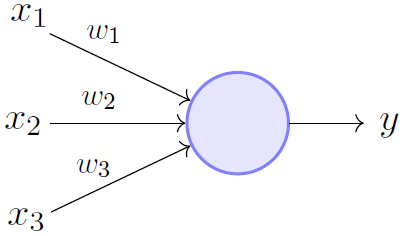

# Convolución

La convolución en el contexto del aprendizaje profundo, específicamente en las redes neuronales convolucionales, es una operación esencial que utiliza filtros deslizantes para extraer características relevantes de los datos de entrada. Esta operación permite capturar relaciones espaciales y locales en imágenes o volúmenes de datos, y ha demostrado ser muy efectiva en tareas de visión por computadora, como clasificación de imágenes, detección de objetos y segmentación.

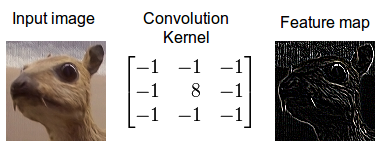

## Funciones de activación

Las funciones de activación son componentes clave en las redes neuronales, ya que introducen la capacidad de no linealidad en el modelo. Estas funciones se aplican a la salida de una neurona y determinan si esa neurona se activa o no.

Una de las funciones de activación más comunes es la función ReLU (Rectified Linear Unit), que activa la neurona si el valor de entrada es mayor que cero y la desactiva si es menor o igual a cero. La función ReLU es ampliamente utilizada debido a su simplicidad y capacidad para lidiar con el problema del desvanecimiento del gradiente.

Otra función de activación popular es la función sigmoide, que produce una salida en el rango de 0 a 1, lo que la hace adecuada para problemas de clasificación binaria. Sin embargo, la función sigmoide puede sufrir del problema del desvanecimiento del gradiente en redes neuronales profundas.

También se utiliza la función tanh (tangente hiperbólica), que produce una salida en el rango de -1 a 1. La función tanh es simétrica alrededor de cero y puede ser útil en ciertos escenarios.

Además de estas funciones, existen otras como la función softmax para clasificación multiclase, la función Leaky ReLU para abordar el problema de la activación "muerta" en ReLU, y la función ELU (Exponential Linear Unit) que combina aspectos de ReLU y sigmoide.

La elección de la función de activación depende del problema y las características de los datos. Las funciones de activación permiten a las redes neuronales aprender representaciones no lineales y capturar relaciones complejas en los datos, lo que las hace fundamentales en el éxito de las redes neuronales.

# Ejercicio: Deblurring de imagenes con capa convolucional

Tenemos el siguiente escenario: los sistemas de imagen se pueden representar como una convolución de la distribución de luz en el sensor, donde el kernel representa el sistema óptico caracterizado que añade deformaciones, desenfoque, entre otras cosas.

Los algoritmos de deblurring intentan mejorar la calidad de una imagen que ha sido distorsionada por distintas fuentes, las cuales pueden ser modeladas como una convolución.

Vamos a simular una deformación de lente y comprobar si una capa convolucional es capaz de reconstruir la imagen optimizando el kernel de convolución.


* Agregar imagen a la carpeta

Downloading...
From: https://drive.google.com/uc?id=1tUt2G9laNdspHkUq2LZHRSMf7FR10Lc6
To: /content/shrek.jpg
100% 22.4k/22.4k [00:00<00:00, 77.3MB/s]


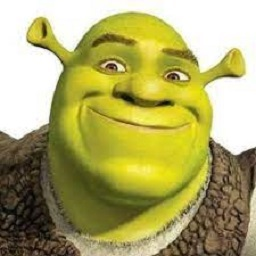

(256, 256)


In [ ]:
!gdown 1tUt2G9laNdspHkUq2LZHRSMf7FR10Lc6
from PIL import Image
# importar imagen desde directorio
image = Image.open('shrek.jpg')
# plot
display(image)
print(image.size)

* Se debe transformar a un arreglo numpy y luego pasar a pytorch.Recordar que para operar con el tensor, se debe expresar en su notación, en este ejemplo como es una imagen a color, debe quedar con dimensiones $1\times 3\times 256\times 256$

In [ ]:
import numpy as np
import torch
device = torch.device('cuda')
data = np.asarray(image)
input_tensor = torch.from_numpy(data).to(device).float()
print(input_tensor.shape)

# Adaptar dimensioines
input_tensor = torch.unsqueeze(input_tensor,0)
print(input_tensor.shape)

input_tensor = input_tensor.permute(0,3,1,2)
print(input_tensor.shape)

torch.Size([256, 256, 3])
torch.Size([1, 256, 256, 3])
torch.Size([1, 3, 256, 256])


<ipython-input-11-f8fd008762a2>:5: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  input_tensor = torch.from_numpy(data).to(device).float()


Ahora supongamos que la imagen es corrompida por un kernel desconocido. El kernel debe tener la misma cantidad de canales que la imagen. Entonces si diseñamos un kernel de aberracion de  $3 \times 3$ y asumimos que afecta de la misma forma a los 3 colores debe quedar $1\times 1\times 3\times 3$.

In [ ]:
import torch.nn.functional as F

grado_distorsion = 7
kernel =  torch.eye(grado_distorsion).to(device) /grado_distorsion
print(kernel)
print(kernel.shape)
kernel = torch.unsqueeze(torch.unsqueeze(kernel,0),0).float()
print(kernel.shape)

pad = grado_distorsion//2

corrR = F.conv2d(input_tensor[:,0:1],kernel,padding=pad)
corrG = F.conv2d(input_tensor[:,1:2],kernel,padding=pad)
corrB = F.conv2d(input_tensor[:,2:],kernel,padding=pad)
corrupted = torch.cat((corrR,corrG,corrB),dim=1)
print(corrupted.shape)

tensor([[0.1429, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1429, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1429, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.1429, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.1429, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1429, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1429]],
       device='cuda:0')
torch.Size([7, 7])
torch.Size([1, 1, 7, 7])
torch.Size([1, 3, 256, 256])


Para ver el resultado de la imagen, podemos usar librerias de python para plotear imagenes (como la usada anteriormente) sin embargo para hacer esto la imagene debe estar alojada en cpu y debe estar en sus dimensiones naturales ($H \times W \times C$). Incorporaremos todo este procedimiento en una funcion:

In [ ]:
import torch
import matplotlib.pyplot as plt

def plot_tensor(tensor):
    # Se mueve el tensor de gpu a cpu
    tensor = tensor.cpu()
    # se transforma a arreglo numpy
    array = tensor.numpy()
    # se deja en dimensiones naturales (H,W,C)
    array = array[0].transpose(1, 2, 0)
    # graficar con matplotlib
    plt.imshow(array)
    plt.show()

Con la funcion podemos ver el resultado de la aberración

input


Imagen corrompida


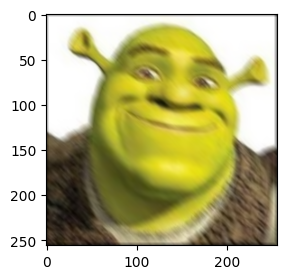

In [ ]:
print("input")
plt.figure(figsize=(3, 3))
plot_tensor(input_tensor/255)

print("Imagen corrompida")
plt.figure(figsize=(3, 3))
plot_tensor(corrupted/255)

La aberración aplicada es el desenfoque de movimiento (motion blur) y puede empeorarla al umentar el valor de ```grado_distorsion ```. Ahora utilizaremos los mismos conceptos del ejemplo anterior, pero en esta ocasión nuestro modelo será una capa convolucional. De esta manera, podremos determinar si es posible reenfocar la imagen

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
device = torch.device('cuda')

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 3, 5,padding=2)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.conv1(x)
        return x


lamb = 0.0005
Epochs = 12000

# Parametros del entrenamiento
model = ConvNet().to(device)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lamb)
loss_val = []
for epo in range(1,Epochs+1):

  # propagacion al modelo
  out_tensor = model(corrupted)
  # Calcular error
  L = loss(input_tensor,out_tensor)
  #Obtener gradientes
  L.backward()

  # update weights
  optimizer.step()

  # zero the gradients after updating
  optimizer.zero_grad()
  if epo % 1200 == 0:
    print(f" epoca {epo} Loss = {L.item():.6f} - learning_rate = {lamb:.8f}")
  if epo % 100 == 0 and epo>0:
    lamb = lamb*0.95
    optimizer = torch.optim.Adam(model.parameters(), lr=lamb)

  # Guardar valores de loss por epoca
  loss_val.append(L.item())

 epoca 1200 Loss = 277.526184 - learning_rate = 0.00028440
 epoca 2400 Loss = 246.330780 - learning_rate = 0.00015368
 epoca 3600 Loss = 236.935486 - learning_rate = 0.00008304
 epoca 4800 Loss = 233.101044 - learning_rate = 0.00004487
 epoca 6000 Loss = 231.176315 - learning_rate = 0.00002425
 epoca 7200 Loss = 230.099701 - learning_rate = 0.00001310
 epoca 8400 Loss = 229.401611 - learning_rate = 0.00000708
 epoca 9600 Loss = 228.959869 - learning_rate = 0.00000383
 epoca 10800 Loss = 228.707443 - learning_rate = 0.00000207
 epoca 12000 Loss = 228.569931 - learning_rate = 0.00000112



Podemos observar la evolución del aprendizaje al graficar la función de pérdida.

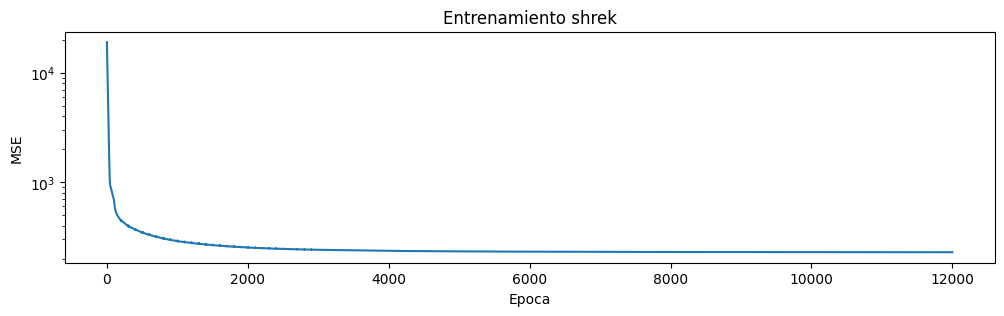

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#Eje x
x = np.arange(len(loss_val))+1

plt.figure(figsize=(12, 3))
# graficar loss
plt.plot(x, loss_val)
plt.yscale('log')
# añadir titulos
plt.xlabel('Epoca')
plt.ylabel('MSE')
plt.title('Entrenamiento shrek')

# Display
plt.show()

Al observar la curva, se puede apreciar un comportamiento típico en el aprendizaje automático. Las redes neuronales son capaces de aprender hasta que llega un punto en el que se estancan. Esto puede deberse a que han alcanzado el mínimo global (el mejor resultado posible) o se han estancado en un mínimo local. Dependiendo de la calidad del resultado, es posible diferenciar entre ambos casos.

La capacidad de una red neuronal para alcanzar una buena solución depende de diversos factores, como la calidad de la base de datos utilizada, la arquitectura empleada y los hiperparámetros seleccionados. Existen numerosas estrategias que se pueden probar para mejorar estos resultados.

Ahora veamos el resultado del entrenamiento.
Para evitar que el modelo calcule los gradientes se deben congelar las capas. Este paso no es escencial pero es eficiente en consumo de memoria.

                   Imagen original  -            Imagen distorsionada         -              Reconstruccion de CNN


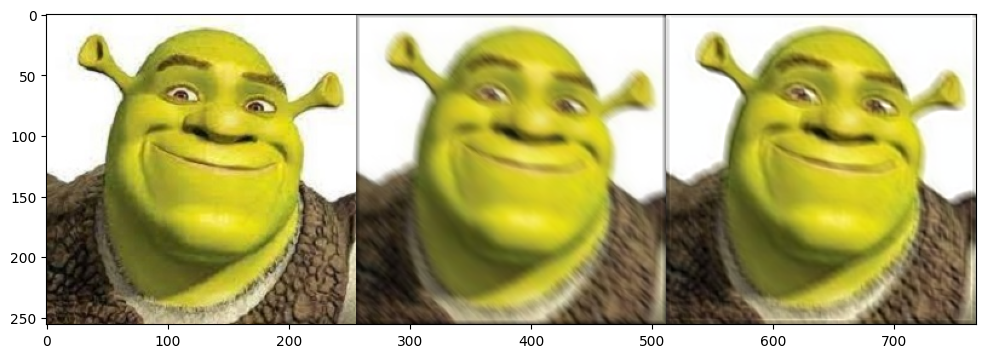

In [ ]:
for param in model.parameters():
    param.requires_grad = False

corrected = model(corrupted.detach())

print("                   Imagen original  -            Imagen distorsionada         -              Reconstruccion de CNN")
plt.figure(figsize=(12, 12))
plot_tensor(torch.cat((input_tensor,corrupted,corrected),dim=3)/255)

A pesar de que la aberración se representa con una capa convolucional, entrenar dicha capa por sí sola no es suficiente para revertir el proceso, ya que la deconvolución es un proceso más complejo. Sin embargo, podríamos explorar si aumentar el tamaño del modelo nos permite obtener mejores resultados.

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
device = torch.device('cuda')

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder
        self.encoder_conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.encoder_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder_conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.encoder_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Decoder
        self.decoder_upconv1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.decoder_conv1 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.decoder_upconv2 = nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2)
        self.decoder_conv2 = nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # Encoder
        x1 = self.encoder_conv1(x)
        x1p = self.encoder_pool1(x1)
        x2 = self.encoder_conv2(x1p)
        x2p = self.encoder_pool2(x2)

        # Decoder
        x_up1 = self.decoder_upconv1(x2p)
        x3 = self.decoder_conv1(x_up1)
        x_up2 = self.decoder_upconv2(x3)
        x_out = self.decoder_conv2(x_up2)

        return x_out


lamb = 0.006
Epochs = 12000

# Parametros del entrenamiento
model = UNet().to(device)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lamb)
loss_val = []
for epo in range(1,Epochs+1):

  # propagacion al modelo
  out_tensor = model(corrupted)
  # Calcular error
  L = loss(input_tensor,out_tensor)
  #Obtener gradientes
  L.backward()

  # update weights
  optimizer.step()

  # zero the gradients after updating
  optimizer.zero_grad()
  if epo % 1200 == 0:
    print(f" epoca {epo} Loss = {L.item():.6f} - learning_rate = {lamb:.8f}")
  if epo % 100 == 0 and epo>0:
    lamb = lamb*0.97
    optimizer = torch.optim.Adam(model.parameters(), lr=lamb)

  # Guardar valores de loss por epoca
  loss_val.append(L.item())

 epoca 1200 Loss = 194.512192 - learning_rate = 0.00429181
 epoca 2400 Loss = 139.071579 - learning_rate = 0.00297784
 epoca 3600 Loss = 85.740868 - learning_rate = 0.00206615
 epoca 4800 Loss = 71.259445 - learning_rate = 0.00143358
 epoca 6000 Loss = 62.816811 - learning_rate = 0.00099468
 epoca 7200 Loss = 57.796257 - learning_rate = 0.00069015
 epoca 8400 Loss = 54.390411 - learning_rate = 0.00047886
 epoca 9600 Loss = 52.156113 - learning_rate = 0.00033225
 epoca 10800 Loss = 50.634018 - learning_rate = 0.00023053
 epoca 12000 Loss = 49.373047 - learning_rate = 0.00015995


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#Eje x
x = np.arange(len(loss_val))+1

plt.figure(figsize=(12, 3))
# graficar loss
plt.plot(x, loss_val)
plt.yscale('log')
# añadir titulos
plt.xlabel('Epoca')
plt.ylabel('MSE')
plt.title('Entrenamiento shrek')

# Display
plt.show()

Si observamos la curva, tiene un comportamiento similar, sin embargo esta vez el error final es mucho menor que el caso anterior, es decir, ahora la reconstruccion debe ser mejor. Veamos el resultado:

                   Imagen original  -            Imagen distorsionada         -              Reconstruccion de CNN


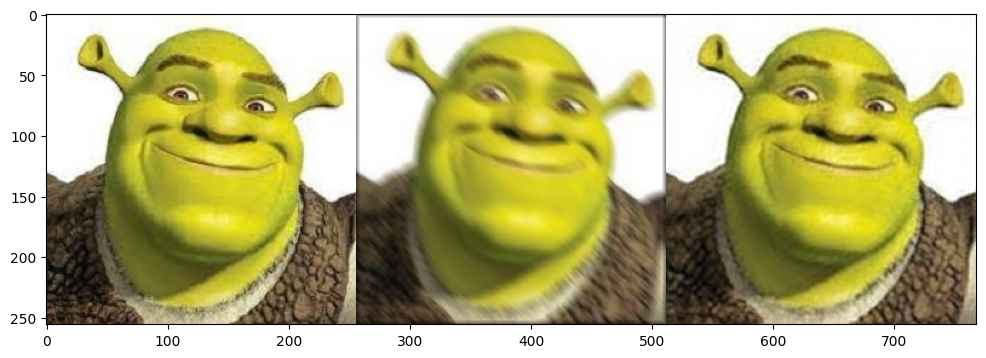

In [ ]:
for param in model.parameters():
    param.requires_grad = False

corrected = model(corrupted.detach())

print("                   Imagen original  -            Imagen distorsionada         -              Reconstruccion de CNN")
plt.figure(figsize=(12, 12))
plot_tensor(torch.cat((input_tensor,corrupted,corrected),dim=3)/255)


Si bien no es perfecta, definitivamente esta reconstruccion es mucho mejor.

Notemos ahora que entrenamos con esta unica imagen, ¿Será posible que pueda reconstruir otra imagen?

Downloading...
From: https://drive.google.com/uc?id=1tTzLO3PIMwg8stiHoEV3tSY3_u2qRK_a
To: /content/mr_inc.jpg
100% 11.6k/11.6k [00:00<00:00, 36.4MB/s]


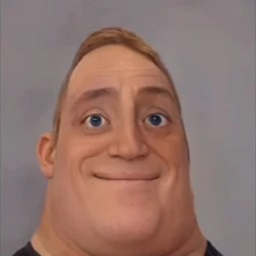

(256, 256)


In [ ]:
!gdown 1tTzLO3PIMwg8stiHoEV3tSY3_u2qRK_a
from PIL import Image
# importar imagen desde directorio
image = Image.open('mr_inc.jpg')
# plot
display(image)
print(image.size)

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
data = np.asarray(image)
device = torch.device('cuda')
input_tensor = torch.from_numpy(data).to(device).float()
# Adaptar dimensioines
input_tensor = torch.unsqueeze(input_tensor,0)
input_tensor = input_tensor.permute(0,3,1,2)


kernel =  torch.eye(grado_distorsion).to(device) /grado_distorsion
kernel = torch.unsqueeze(torch.unsqueeze(kernel,0),0).float()

corrR = F.conv2d(input_tensor[:,0:1],kernel,padding=pad)
corrG = F.conv2d(input_tensor[:,1:2],kernel,padding=pad)
corrB = F.conv2d(input_tensor[:,2:],kernel,padding=pad)
corrupted = torch.cat((corrR,corrG,corrB),dim=1)
print(corrupted.shape)

torch.Size([1, 3, 256, 256])


                   Imagen original  -            Imagen distorsionada         -              Reconstruccion de CNN


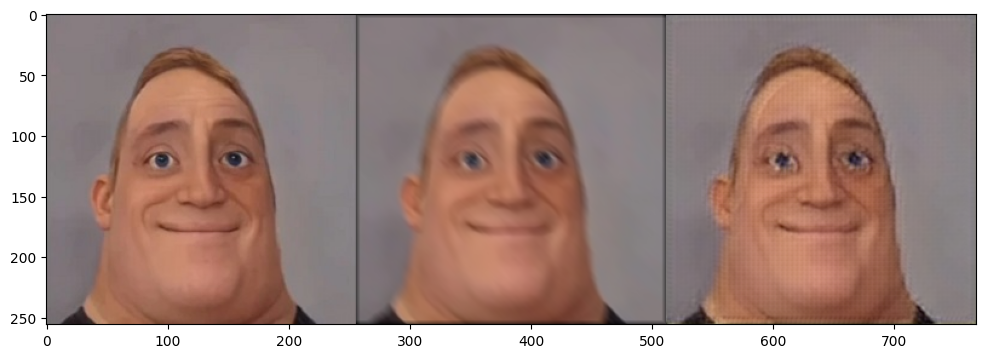

In [ ]:
for param in model.parameters():
    param.requires_grad = False

corrected = model(corrupted.detach())

print("                   Imagen original  -            Imagen distorsionada         -              Reconstruccion de CNN")
plt.figure(figsize=(12, 12))
plot_tensor(torch.cat((input_tensor,corrupted,corrected),dim=3)/255)

Puedes notar que en este caso la red no es capaz de reconstruir la imagen. Esto se debe a que al entrenar únicamente con una imagen, la red ha sufrido de sobreajuste (overfitting) y se ha especializado en reconstruir esa imagen específica.

Una de las formas más efectivas de combatir el sobreajuste es entrenar el modelo con una base de datos que tenga una diversidad adecuada. Esto permite que la red neuronal aprenda patrones generales en lugar de memorizar detalles específicos de una sola imagen. Al exponer el modelo a una variedad de ejemplos, se promueve una mejor generalización y capacidad de reconstrucción en diferentes escenarios.


En este ultimo ejercicio de este taller, haremos un entrenamiento estandar de regresion con un dataset de imagenes.

# Preparar dataset

Bajaremos un pequeño dataset de varias caras de famosos de un tamaño de $256\times 256$, esto a modo de simplificar el procesamiento de las imagenes. En teoria, al usar un modelo neuronal convolucional como UNET, la red puede procesar con resoluciones espaciales arbitrarias.


In [ ]:
!gdown 1tAK7DMa7GzD0i5FRydtUNJVTQXYj4Fpx
!unzip celeba_hq_256.zip -d dataset

Downloading...
From: https://drive.google.com/uc?id=1tAK7DMa7GzD0i5FRydtUNJVTQXYj4Fpx
To: /content/celeba_hq_256.zip
100% 6.58M/6.58M [00:00<00:00, 88.3MB/s]
Archive:  celeba_hq_256.zip
  inflating: dataset/celeba_hq_256/00000.jpg  
  inflating: dataset/celeba_hq_256/00001.jpg  
  inflating: dataset/celeba_hq_256/00002.jpg  
  inflating: dataset/celeba_hq_256/00003.jpg  
  inflating: dataset/celeba_hq_256/00004.jpg  
  inflating: dataset/celeba_hq_256/00005.jpg  
  inflating: dataset/celeba_hq_256/00006.jpg  
  inflating: dataset/celeba_hq_256/00007.jpg  
  inflating: dataset/celeba_hq_256/00008.jpg  
  inflating: dataset/celeba_hq_256/00009.jpg  
  inflating: dataset/celeba_hq_256/00010.jpg  
  inflating: dataset/celeba_hq_256/00011.jpg  
  inflating: dataset/celeba_hq_256/00012.jpg  
  inflating: dataset/celeba_hq_256/00013.jpg  
  inflating: dataset/celeba_hq_256/00014.jpg  
  inflating: dataset/celeba_hq_256/00015.jpg  
  inflating: dataset/celeba_hq_256/00016.jpg  
  inflating: da

A continuación se definira el objeto que se encargara de gestionar nuestro dataset. El manejo de datasets necesita realizar las siguientes acciones:


1.   Leer el archivo desde el fichero, hacia la memoria RAM del computados, para esto se utilizara la libreria PIL ya que leeremos imagenes jpg, las primeras dos lineas de la funcion __getitem__, la primera linea gestiona la ruta en el directorio y la segundo carga el archivo a la variable image.
2.   Procesar la imagen para ser utilizara por pytorch. Esn este caso uno puede procesar la imagen cambiando el tamaño, cortar, cambiar color etc. En este ejemplo la unica operacion sera convertir la imagen PIL a tensor.

3.   Como nuestro dataset solo tiene imagenes sin corromper por el desenfoque, debemos crear una version del dataset que tenga las mismas imagenes corrompidas, para eso son las siguientes lineas de la clase CustomDataset.


Una vez creada y declarada la clase, este objeto se encarga de realizar la gestion de batch, es decir enviar una porcion aleatoria del dataset, esto a fin de no saturar la memoria de video. El parametro batch_size se puede declarar cuantas imagenes del dataset se cargaran cada vez.

Como ejemplo al final de esta celda se llaman y plotean algunas imagenes del dataset a traves del objeto.


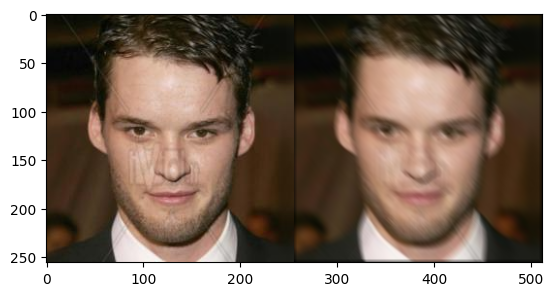

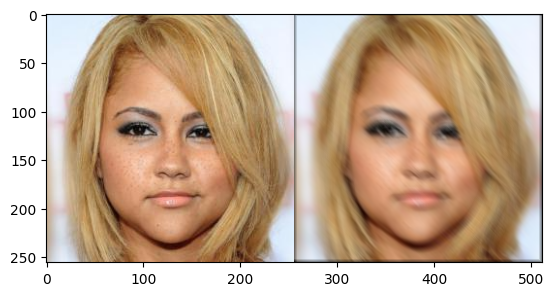

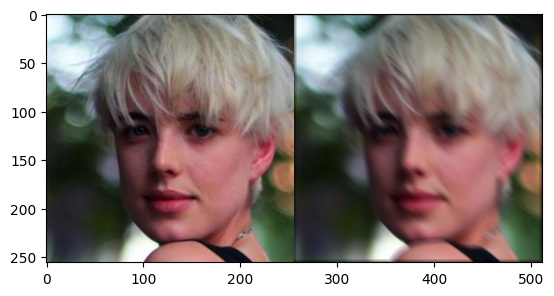

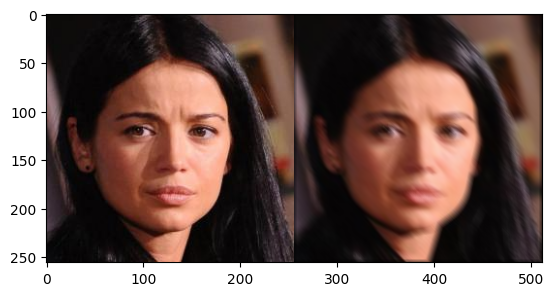

In [ ]:
import os
import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F

class CustomDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.image_paths = glob.glob(os.path.join(data_dir, "*.jpg"))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)

        transform = transforms.Compose([
            transforms.ToTensor()
        ])

        image = transform(image)
        kernel =  torch.eye(7)/7
        kernel = torch.unsqueeze(torch.unsqueeze(kernel,0),0).float()
        pad = 7//2
        corrR = F.conv2d(image.unsqueeze(0)[:,0:1],kernel,padding=pad)
        corrG = F.conv2d(image.unsqueeze(0)[:,1:2],kernel,padding=pad)
        corrB = F.conv2d(image.unsqueeze(0)[:,2:],kernel,padding=pad)
        corrupted = torch.cat((corrR,corrG,corrB),dim=1)
        return image,corrupted[0]


dataset = CustomDataset("dataset/celeba_hq_256/")

batch_size = 32  # Adjust this based on your system's memory
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
cont=0
for batch in dataloader:
  plot_tensor(torch.cat((batch[0],batch[1]),dim=3))
  cont +=1
  if cont == 5:
    break

In [ ]:
import torch.nn as nn
import numpy as np
from PIL import Image
device = torch.device('cuda')

class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetBlock, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        return out

# U-Net
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, num_blocks=2):
        super(UNet, self).__init__()

        # Contracting Path (Encoder)
        self.encoder_blocks = nn.ModuleList()
        for _ in range(num_blocks):
            self.encoder_blocks.append(UNetBlock(in_channels, 64))
            in_channels = 64

        # Bottleneck
        self.bottleneck = UNetBlock(64,64)

        # Expansive Path (Decoder)
        self.decoder_blocks = nn.ModuleList()
        for _ in range(num_blocks):
            self.decoder_blocks.append(UNetBlock(64 * 2, 64))  # Concatenate skip connection

        # Final convolutional layer
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Encoder
        for block in self.encoder_blocks:
            x = block(x)
            skip_connections.append(x)
            x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder
        for block in self.decoder_blocks:
            skip = skip_connections.pop()
            x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
            x = torch.cat([x, skip], dim=1)
            x = block(x)

        # Final convolution
        x = self.final_conv(x)
        return x


lamb = 0.0001
Epochs = 160

# Parametros del entrenamiento
model = UNet().to(device)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lamb)
loss_val = []
for epo in range(1,Epochs+1):

  for batch in dataloader:

    corrompida = batch[1].to(device)
    original   = batch[0].to(device)

    # propagacion al modelo
    out_tensor = model(corrompida)
    # Calcular error
    L = loss(original,out_tensor)
    #Obtener gradientes
    L.backward()

    # update weights
    optimizer.step()

    # zero the gradients after updating
    optimizer.zero_grad()

    # Guardar valores de loss por epoca
    loss_val.append(L.item())

  if epo % 20 == 0 and epo>40:
    lamb = lamb*0.90
    optimizer = torch.optim.Adam(model.parameters(), lr=lamb)
  print(f" epoca {epo} Loss = {L.item():.6f} - learning_rate = {lamb:.8f}")


    # Use the batch of tensors for training

 epoca 1 Loss = 0.251353 - learning_rate = 0.00010000
 epoca 2 Loss = 0.038450 - learning_rate = 0.00010000
 epoca 3 Loss = 0.015218 - learning_rate = 0.00010000
 epoca 4 Loss = 0.014286 - learning_rate = 0.00010000
 epoca 5 Loss = 0.013043 - learning_rate = 0.00010000
 epoca 6 Loss = 0.009847 - learning_rate = 0.00010000
 epoca 7 Loss = 0.010997 - learning_rate = 0.00010000
 epoca 8 Loss = 0.008890 - learning_rate = 0.00010000
 epoca 9 Loss = 0.005608 - learning_rate = 0.00010000
 epoca 10 Loss = 0.004161 - learning_rate = 0.00010000
 epoca 11 Loss = 0.003678 - learning_rate = 0.00010000
 epoca 12 Loss = 0.002622 - learning_rate = 0.00010000
 epoca 13 Loss = 0.002858 - learning_rate = 0.00010000
 epoca 14 Loss = 0.002596 - learning_rate = 0.00010000
 epoca 15 Loss = 0.002449 - learning_rate = 0.00010000
 epoca 16 Loss = 0.002648 - learning_rate = 0.00010000
 epoca 17 Loss = 0.002094 - learning_rate = 0.00010000
 epoca 18 Loss = 0.002194 - learning_rate = 0.00010000
 epoca 19 Loss = 0.

                   Imagen original  -            Imagen distorsionada         -              Reconstruccion de CNN


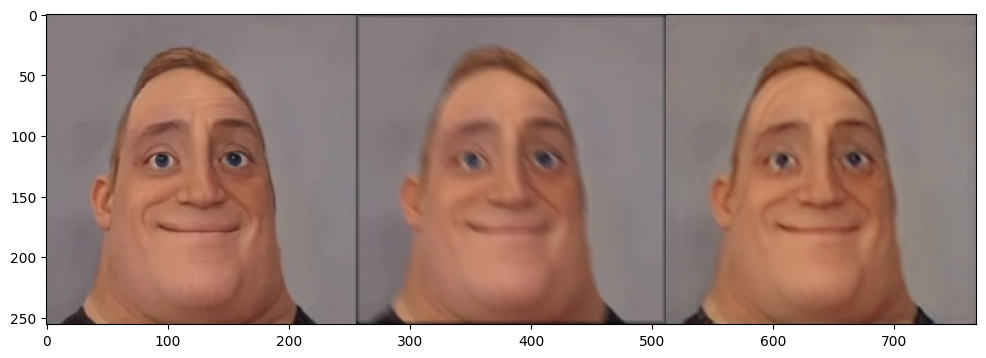

In [ ]:
data = np.asarray(image)
input_tensor = torch.from_numpy(data).to(device).float()
# Adaptar dimensioines
input_tensor = torch.unsqueeze(input_tensor,0)
input_tensor = input_tensor.permute(0,3,1,2)

pad = 7//2
kernel =  torch.eye(7).to(device) /7
kernel = torch.unsqueeze(torch.unsqueeze(kernel,0),0).float()

corrR = F.conv2d(input_tensor[:,0:1],kernel,padding=pad)
corrG = F.conv2d(input_tensor[:,1:2],kernel,padding=pad)
corrB = F.conv2d(input_tensor[:,2:],kernel,padding=pad)
corrupted = torch.cat((corrR,corrG,corrB),dim=1)


for param in model.parameters():
    param.requires_grad = False

corrected = model(corrupted.detach())

print("                   Imagen original  -            Imagen distorsionada         -              Reconstruccion de CNN")
plt.figure(figsize=(12, 12))
plot_tensor(torch.cat((input_tensor,corrupted,corrected),dim=3)/255)